In [1]:
import open3d as o3d
import numpy as np
import time
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# High Resolution Case (easier)

### Load pointcloud

In [2]:
N = 1 #in this case we want just one iteration
demo_pcd = o3d.data.DemoICPPointClouds()

#load the pointclouds, in this case they are identical
source_pcd = o3d.io.read_point_cloud(demo_pcd.paths[0])
target_pcd = o3d.io.read_point_cloud(demo_pcd.paths[0])

pov_params = {
			"front" : [ 0.089973012143928194, -0.29991004047976066, -0.94971512818590864 ],
			"lookat" : [ 2.5434239349162109, 1.5730119349248795, 0.33563518176474566 ],
			"up" : [ -0.070000000000000007, -0.94999999999999996, 0.28999999999999998 ],
			"zoom" : 0.17999999999999983
		}

o3d.visualization.draw_geometries([source_pcd],
                                  **pov_params)



### Transform pointcloud

In [3]:
from functions import draw_registration_result

#create a random rotation angle theta
thetas = np.random.uniform(low=-np.pi, high=np.pi, size=N)
theta = thetas[0]

#apply rotation
transformation_x = np.array([
    [1, 0, 0, 0],
    [0, np.cos(theta), np.sin(theta), 0],
    [0, -np.sin(theta), np.cos(theta), 0],
    [0, 0, 0, 1]
])

transformation_y = np.array([
    [np.cos(theta), 0, -np.sin(theta), 0],
    [0, 1, 0, 0],
    [np.sin(theta), 0, np.cos(theta), 0],
    [0, 0, 0, 1]
])

transformation_z = np.array([
    [np.cos(theta), -np.sin(theta), 0, 0],
    [np.sin(theta), np.cos(theta), 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

s_pcd = copy.deepcopy(source_pcd)
t_pcd = copy.deepcopy(target_pcd)

s_pcd.transform(transformation_x)
s_pcd.transform(transformation_y)
s_pcd.transform(transformation_z)

s_pcd.translate(-s_pcd.get_center())
t_pcd.translate(-t_pcd.get_center())

pov_params = {
			"front" : [ 0.089973012143928194, -0.29991004047976066, -0.94971512818590864 ],
			"lookat" : [ 0.28646049621666131, 0.043310735861716056, 0.59914777360415561 ],
			"up" : [ -0.070000000000000007, -0.94999999999999996, 0.28999999999999998 ],
			"zoom" : 0.56000000000000005
		}
draw_registration_result(s_pcd, t_pcd, np.eye(4), pov_params=pov_params)

### Preprocess point cloud

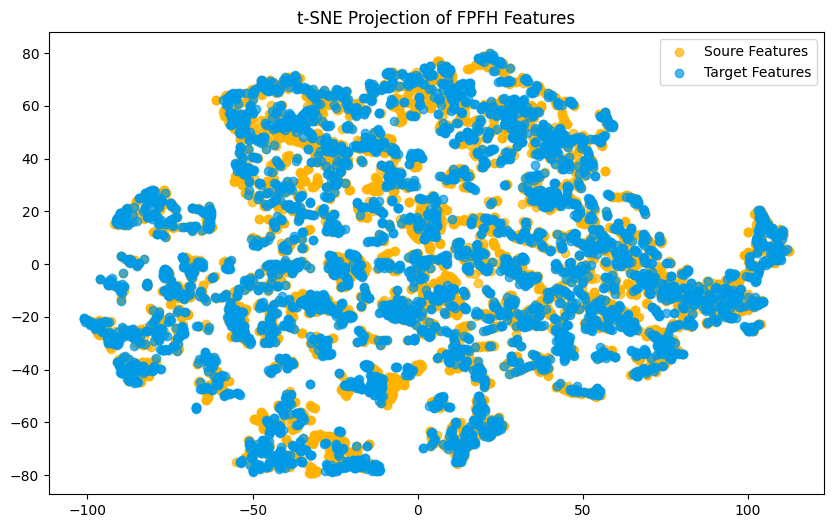

In [4]:
from functions import prepare_point_cloud, visualize_fpfh_tsne

s_down, s_fpfh = prepare_point_cloud(s_pcd)
t_down, t_fpfh = prepare_point_cloud(t_pcd)

#downsampled point cloud
o3d.visualization.draw_geometries([t_down], **pov_params)

#estimated normals
o3d.visualization.draw_geometries([t_down], point_show_normal=True, **pov_params)

#t-SNE projection of FPFH features
visualize_fpfh_tsne(s_fpfh, t_fpfh)

## RANSAC Global Registration

In [5]:
from functions import ransac_global_registration, test_high_res

ransac = ransac_global_registration

transformation_ransac, scores_ransac = test_high_res(s_pcd, thetas, ransac)

print(scores_ransac)

draw_registration_result(s_pcd, t_pcd, transformation_ransac[0], pov_params=pov_params)

[{'Fitness': 1.0, 'RMSE': 0.09854965582726204, 'Time': 0.5621793270111084}]


In [6]:
from functions import fast_global_registration

fgr = fast_global_registration

transformation_fgr, scores_fgr = test_high_res(s_pcd, thetas, fgr)

print(scores_fgr)

draw_registration_result(s_pcd, t_pcd, transformation_fgr[0], pov_params=pov_params)

[{'Fitness': 1.0, 'RMSE': 0.0528558389947372, 'Time': 0.23746895790100098}]


# Multiple Objects Case (harder)

### Load Pointclouds

In [2]:
from functions import draw_registration_result

source_pcd = o3d.io.read_point_cloud("dataset/test_x/iteration_0_frames_1_to_11.ply")
target = o3d.io.read_triangle_mesh("./objects/untitled.ply")
target_pcd = target.sample_points_poisson_disk(5000)
validation_pcd = o3d.io.read_point_cloud("dataset/test_y/iteration_0_frames_1_to_11.ply")

pov_params = {
			"front" : [ 0.27107076868580937, -0.87306606481734872, 0.40531010945747897 ],
			"lookat" : [ -2.9162329904845934, 0.912432878139804, 0.37579865583464739 ],
			"up" : [ -0.022184829022185396, 0.41529685743522626, 0.90941539109786462 ],
			"zoom" : 0.43999999999999972
		}

draw_registration_result(source_pcd, target_pcd, np.eye(4), pov_params=pov_params)

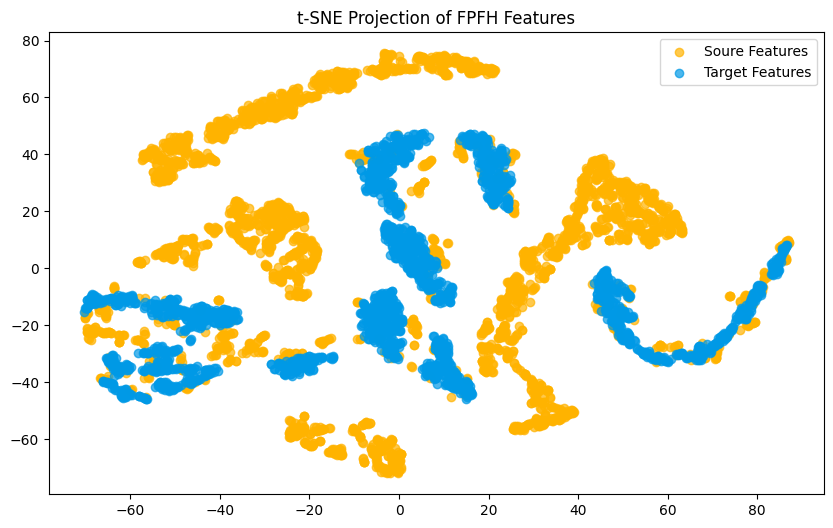

In [3]:
from functions import prepare_point_cloud, visualize_fpfh_tsne

s_pcd = copy.deepcopy(source_pcd)
t_pcd = copy.deepcopy(target_pcd)

s_down, s_fpfh = prepare_point_cloud(s_pcd)
t_down, t_fpfh = prepare_point_cloud(t_pcd)

#downsampled point cloud
draw_registration_result(s_down, t_down, np.eye(4), pov_params)

#estimated normals
pov_params["point_show_normal"] = True
draw_registration_result(s_down, t_down, np.eye(4), pov_params)

#t-SNE projection of FPFH features
visualize_fpfh_tsne(s_fpfh, t_fpfh)

In [4]:
from functions import test_multiple_objects, ransac_global_registration

ransac = ransac_global_registration

transforms_ransac, score_ransac = test_multiple_objects([source_pcd], [target], ransac, [validation_pcd], distance_threshold=0.5)
print(score_ransac)

pov_params = {
			"front" : [ 0.26373367737055031, -0.36405463459376902, 0.89325739316918285 ],
			"lookat" : [ 1.2811559995676269, 1.6328134586586056, -3.3068485075711309 ],
			"up" : [ -0.21480780149331333, -0.92495565452707451, -0.31355166332839102 ],
			"zoom" : 0.82000000000000006
		}

draw_registration_result(s_down, t_down, transforms_ransac[0], pov_params)

[{'Fitness': 0.3880097382836275, 'RMSE': 0.11861982720515396, 'Time': 10.892907857894897}]


In [5]:
from functions import fast_global_registration

fgr = fast_global_registration

transforms_fgr, score_fgr = test_multiple_objects([source_pcd], [target], fgr, [validation_pcd], distance_threshold=0.5)
print(score_fgr)

draw_registration_result(s_pcd, t_pcd, transforms_fgr[0], pov_params)

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. open3d.cuda.pybind.pipelines.registration.FastGlobalRegistrationOption(arg0: open3d.cuda.pybind.pipelines.registration.FastGlobalRegistrationOption)
    2. open3d.cuda.pybind.pipelines.registration.FastGlobalRegistrationOption(division_factor: float = 1.4, use_absolute_scale: bool = False, decrease_mu: bool = False, maximum_correspondence_distance: float = 0.025, iteration_number: int = 64, tuple_scale: float = 0.95, maximum_tuple_count: int = 1000, tuple_test: bool = True)

Invoked with: kwargs: max_correspondence_distance=0.05